# 디지코디그리 STEP-3 개인 과제

## 과제 내용 상세

- 시계열분석을 통한 장비 고장 시기 예측
- 장비의 에러 로그 카운트를 수집하여 과거 경험을 바탕으로 일정 수 이상의 에러 발생 시점을 예측
- 제약조건: 실 장비 에러 로그 수량을 수집할 수 없어 STEP-3 과정 중 예제 데이터인 FRED Industrial Production:Utilities:Electric and Gas Utilities 데이터를 에러 로그의 카운트로 사용
- 데이터 다운로드 경로: https://fred.stlouisfed.org/series/IPG2211A2N
- 상기 데이터는 1940.01 ~ 2020.12 까지의 EngergyIndex 로 매월 1일의 데이터 값을 가지고 있음
- 하기 실습 과제는 2010.01 ~ 2020.12 데이터만 사용하고 각 데이터는 월평균으로 가정하고 모델링

## 라이브러리 로딩 및 데이터 준비

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('./IPG2211A2N.csv', index_col='DATE', parse_dates=True)

In [4]:
df.head()

,IPG2211A2N
DATE,
1939-01-01,3.3336
1939-02-01,3.3591
1939-03-01,3.4354
1939-04-01,3.4609
1939-05-01,3.4609


In [5]:
df.index.freq = 'MS'

In [6]:
df.columns = ['error_cnt']

In [7]:
ts = df.loc['2010-01-01':'2020-12-01'].copy()

In [8]:
ts.head()

,error_cnt
DATE,
2010-01-01,117.4737
2010-02-01,109.1060
2010-03-01,96.8805
2010-04-01,84.9776
2010-05-01,89.4931


In [9]:
ts.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2010-01-01 to 2020-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   error_cnt  132 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [10]:
ts.isna().sum()

error_cnt    0
dtype: int64

## 원데이터 Time Plot 확인

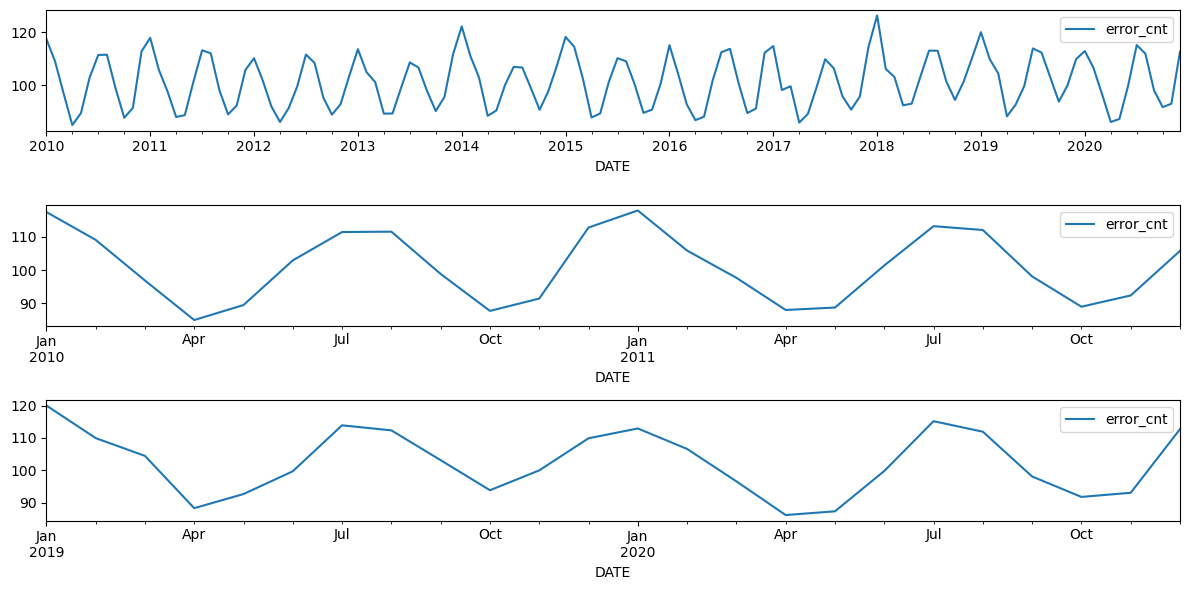

In [11]:
fig, ax = plt.subplots(3,1,figsize=(12,6))
ts.plot(ax=ax[0])
ts.iloc[:24].plot(ax=ax[1])
ts.iloc[-24:].plot(ax=ax[2])
plt.tight_layout()
plt.show()

## 정상성 시계열 여부 확인 (ADFuller Test)

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
s, pvalue, _, _, cv, _ = adfuller(ts.error_cnt)

In [14]:
print('Augmented Dicky-Fuller Test')
print(f' statistics= {s:,.4f}')
print(f' pvalue= {pvalue:,.4f} ==> {"H0기각 - 정상성 시계열" if pvalue < 0.05 else "H0채택 - 비정상성 시계열"}')
print(f' critical values {cv}')

Augmented Dicky-Fuller Test
 statistics= -2.1537
 pvalue= 0.2235 ==> H0채택 - 비정상성 시계열
 critical values {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}


## 추세 변동 추출 (Hodric-Prescott Filter)

In [15]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [16]:
cycle, trend = hpfilter(ts.error_cnt, lamb=129600)

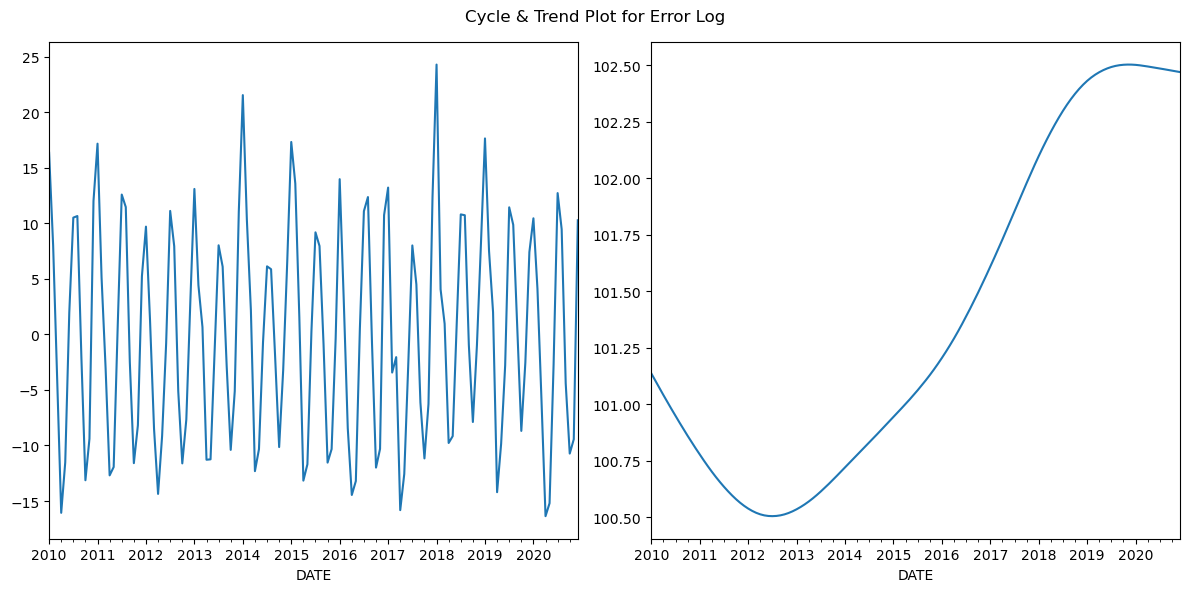

In [17]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
cycle.plot(ax=ax[0])
trend.plot(ax=ax[1])
fig.suptitle('Cycle & Trend Plot for Error Log')
plt.tight_layout()
plt.show()

In [18]:
import statsmodels.api as sm

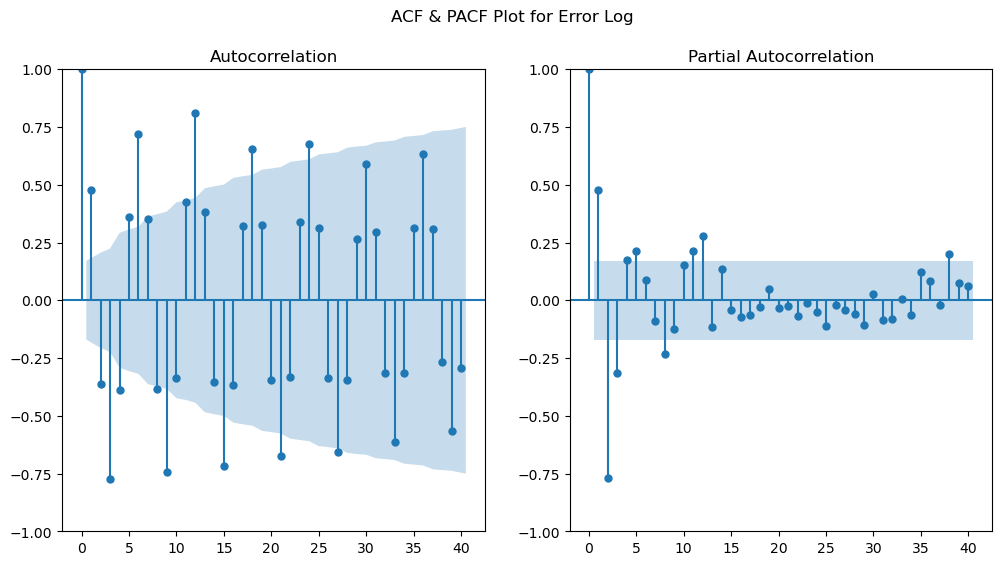

In [19]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
sm.graphics.tsa.plot_acf(ts.error_cnt, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(ts.error_cnt, lags=40, ax=ax[1])
fig.suptitle('ACF & PACF Plot for Error Log')
plt.show()

## 계절설 변동 추출

### SMA, EWMA

In [20]:
ts['6M-SMA'] = ts['error_cnt'].rolling(window=6).mean()

In [21]:
ts['6M-EWMA'] = ts['error_cnt'].ewm(span=6).mean()

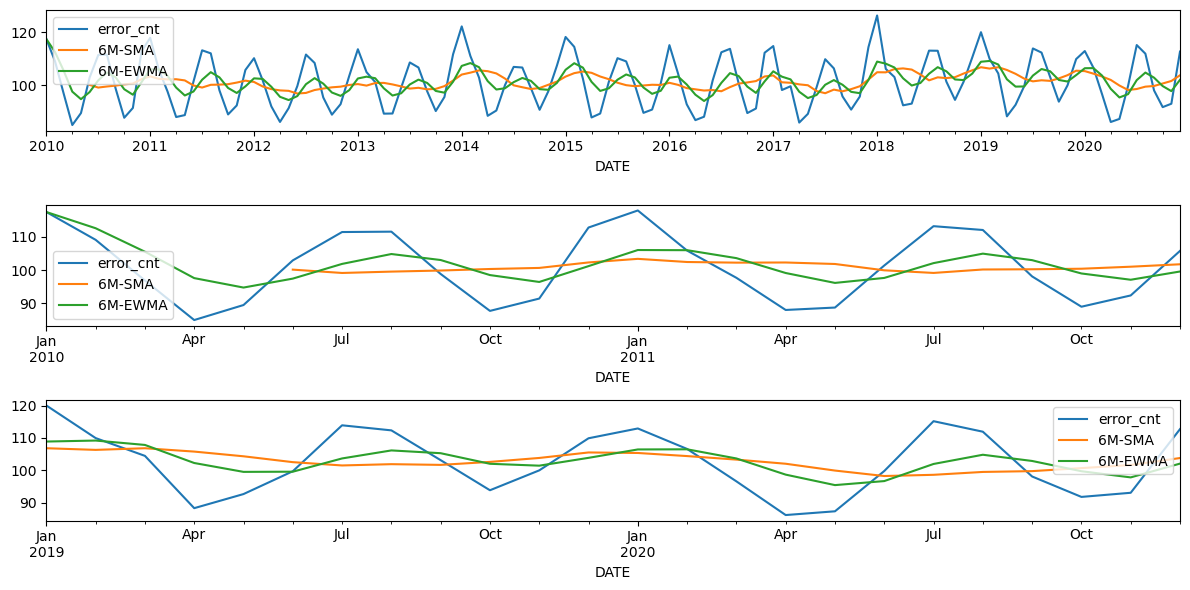

In [22]:
fig, ax = plt.subplots(3,1,figsize=(12,6))
ts.plot(ax=ax[0])
ts.iloc[:24].plot(ax=ax[1])
ts.iloc[-24:].plot(ax=ax[2])
plt.tight_layout()
plt.show()

### Holt-Winters

In [23]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

In [24]:
ts['SES-6M'] = SimpleExpSmoothing(ts.error_cnt).fit(smoothing_level=2/(6+1), optimized=False).fittedvalues.shift(-1)

In [25]:
ts['DES-6M'] = ExponentialSmoothing(ts.error_cnt, trend='multiplicative').fit().fittedvalues.shift(-1)

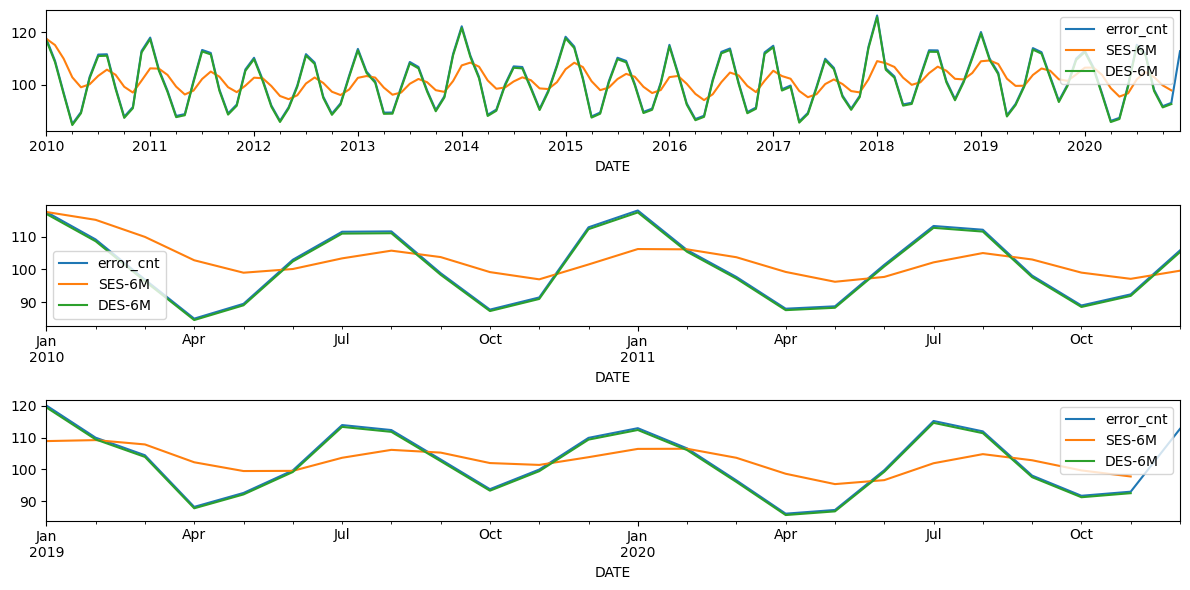

In [26]:
fig, ax = plt.subplots(3,1,figsize=(12,6))
ts[['error_cnt', 'SES-6M', 'DES-6M']].plot(ax=ax[0])
ts[['error_cnt', 'SES-6M', 'DES-6M']][:24].plot(ax=ax[1])
ts[['error_cnt', 'SES-6M', 'DES-6M']][-24:].plot(ax=ax[2])
plt.tight_layout()
plt.show()

In [27]:
ts['TES-6M'] = ExponentialSmoothing(ts.error_cnt, trend='multiplicative', seasonal='multiplicative', seasonal_periods=6).fit().fittedvalues

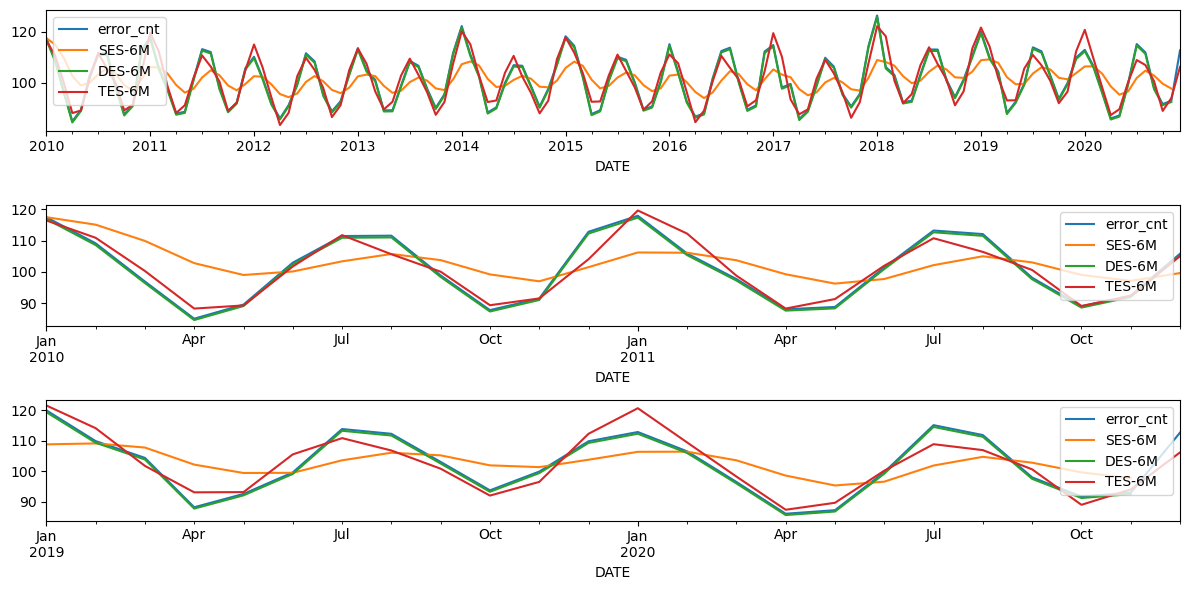

In [28]:
fig, ax = plt.subplots(3,1,figsize=(12,6))
ts[['error_cnt', 'SES-6M', 'DES-6M', 'TES-6M']].plot(ax=ax[0])
ts[['error_cnt', 'SES-6M', 'DES-6M', 'TES-6M']][:24].plot(ax=ax[1])
ts[['error_cnt', 'SES-6M', 'DES-6M', 'TES-6M']][-24:].plot(ax=ax[2])
plt.tight_layout()
plt.show()

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [30]:
decomposition_result = seasonal_decompose(ts.error_cnt, model='multiplicative', period=6)

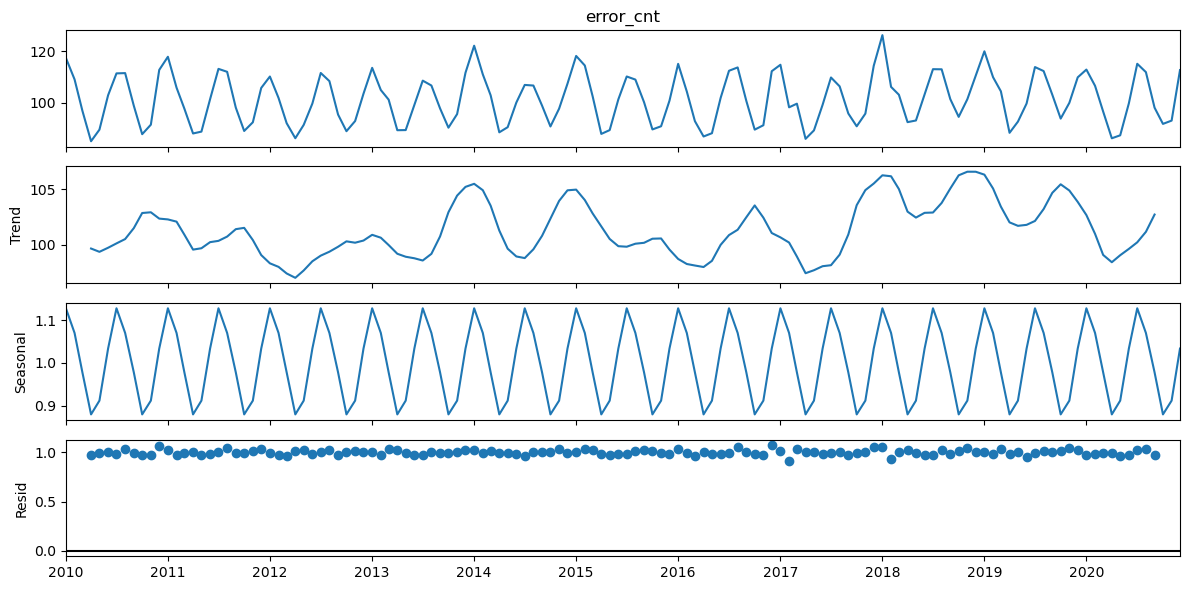

In [31]:
fig = decomposition_result.plot()
fig.set_size_inches((12,6))
fig.tight_layout()
plt.show()

## ACF 및 PACF 확인

In [32]:
import statsmodels.api as sm

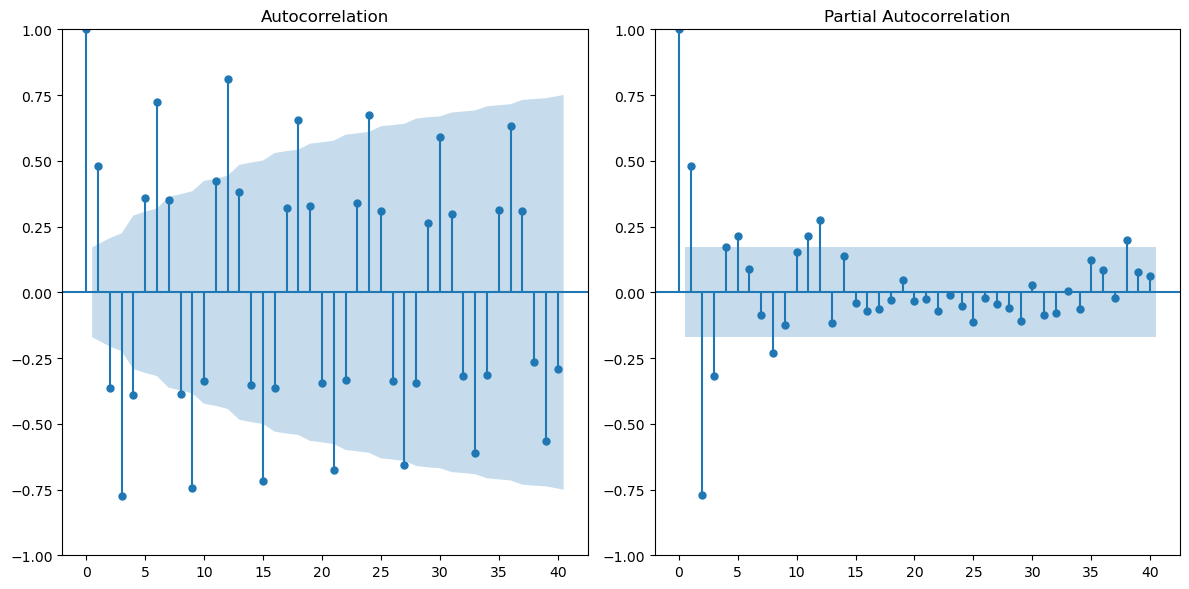

In [33]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
sm.graphics.tsa.plot_acf(ts.error_cnt, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(ts.error_cnt, lags=40, ax=ax[1])
plt.tight_layout()
plt.show()

## ARIMA Model (w/ Auto-ARIMA)

In [34]:
import pmdarima as pm

In [35]:
pm.auto_arima(ts.error_cnt, 
              start_p=0, max_p=10,
              d=1,
              start_q=0, max_q=10,
              D=1, 
              m=6, 
              start_P=0, max_P=10,
              start_Q=0, max_Q=10,
              seasonal=True, 
              stepwise=True,
              trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=824.026, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=703.680, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=821.781, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=703.245, Time=0.06 sec
 ARIMA(1,1,0)(3,1,0)[6]             : AIC=702.226, Time=0.11 sec
 ARIMA(1,1,0)(4,1,0)[6]             : AIC=702.752, Time=0.17 sec
 ARIMA(1,1,0)(3,1,1)[6]             : AIC=inf, Time=0.67 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(4,1,1)[6]             : AIC=inf, Time=1.04 sec
 ARIMA(0,1,0)(3,1,0)[6]             : AIC=710.639, Time=0.07 sec
 ARIMA(2,1,0)(3,1,0)[6]             : AIC=694.029, Time=0.15 sec
 ARIMA(2,1,0)(2,1,0)[6]             : AIC=694.259, Time=0.08 sec
 ARIMA(2,1,0)(4,1,0)[6]             : AIC=695.706, Time=0.25 sec
 ARIMA(2,1,0)(3,1,1)[6]             : AIC=inf, Time=0.75 sec
 A

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(3, 1, 0, 6),
      suppress_warnings=True, with_intercept=False)

In [36]:
model = sm.tsa.arima.ARIMA(ts.error_cnt, order=(2,1,0), seasonal_order=(3,1,0,6))

In [37]:
result = model.fit()

In [38]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                       error_cnt   No. Observations:                  132
Model:             ARIMA(2, 1, 0)x(3, 1, 0, 6)   Log Likelihood                -341.014
Date:                         Tue, 26 Sep 2023   AIC                            694.029
Time:                                 01:17:19   BIC                            710.999
Sample:                             01-01-2010   HQIC                           700.923
                                  - 12-01-2020                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3912      0.083     -4.687      0.000      -0.555      -0.228
ar.L2         -0.2936      0.079     -3.717      0.000      -0.448      -0.139
ar.S.L6       -0.9980      0.099    -10.130      0.000      -1.191      -0.805
ar.S.L12      -0.3331      0.139     -2.393      0.017      -0.606      -0.060
ar.S.L18      -0.1454      0.106     -1.372      0.170      -0.353       0.062
sigma2        12.9081      1.691      7.635      0.000       9.594      16.222
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.87   Prob(JB):                         0.80
Heteroskedasticity (H):               1.56   Skew:                             0.15
Prob(H) (two-sided):                  0.15   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

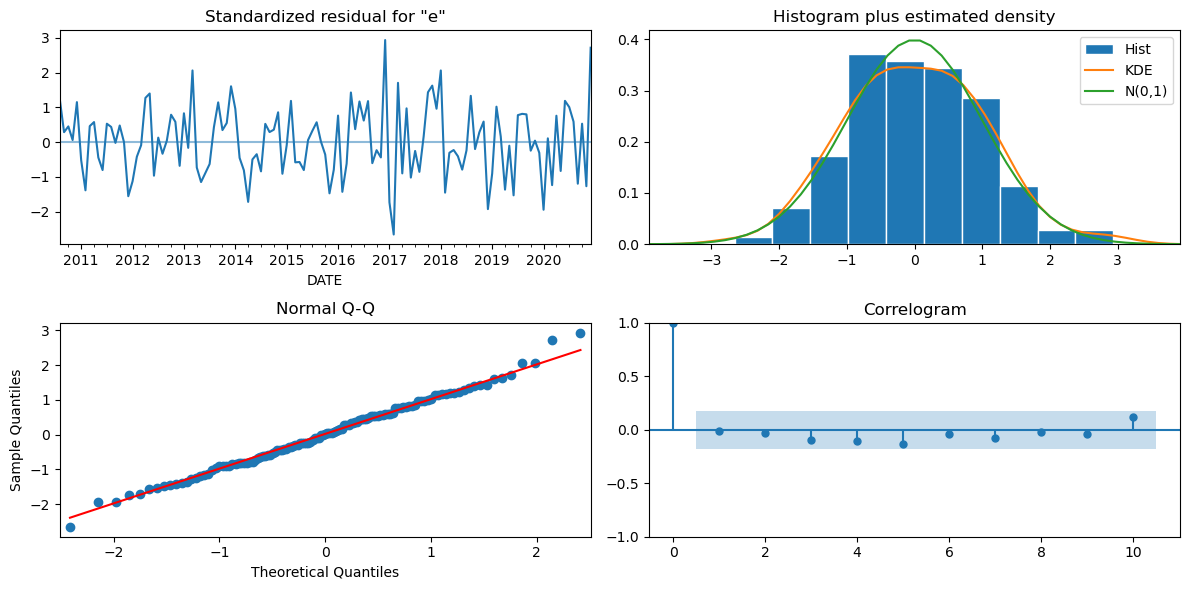

In [39]:
result.plot_diagnostics(figsize=(12,6))
plt.tight_layout()
plt.show()

## 12개월 값 예측

In [40]:
result.forecast(steps=12)

2021-01-01    116.122406
2021-02-01    108.142542
2021-03-01    100.486185
2021-04-01     89.402907
2021-05-01     91.515791
2021-06-01    102.926785
2021-07-01    115.890816
2021-08-01    112.213325
2021-09-01     99.763579
2021-10-01     92.243555
2021-11-01     94.200248
2021-12-01    111.111575
Freq: MS, Name: predicted_mean, dtype: float64